#### Last Modified: August 15th, 2022 (Opal).

## sOpInf Applied to MAS Full Sun (3D) Solar Wind Radial Speed Dataset for CR2210


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM-Revised


In [2]:
import numpy as np
import scipy
import scipy.linalg as la
from scipy import signal
from scipy import  stats
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.model.variable import Variable
import rom_operator_inference as roi
from MHD.notebook_functions import regularizer
from scipy.interpolate import RegularGridInterpolator
import time
import astropy.units as u
import cv2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

### Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
# read in MHD velocity results. 
vr_model = model['vr']

In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [6]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

# save radial velocity 
V = np.array(f)

In [8]:
V.shape

(129, 111, 140)

### Background:  Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [9]:
def periodic_corr_2d(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return scipy.signal.correlate2d(x, np.concatenate((y[1:, :], y)), mode='valid')

In [10]:
v1 = V[:, :, 0]

shift_vec = [0]

for ii in range(1, len(r)):
    v2 = V[:, :, ii]
    corr = periodic_corr_2d(v1, v2)
    shift_vec.append(-p[np.argmax(corr)]*180/np.pi)

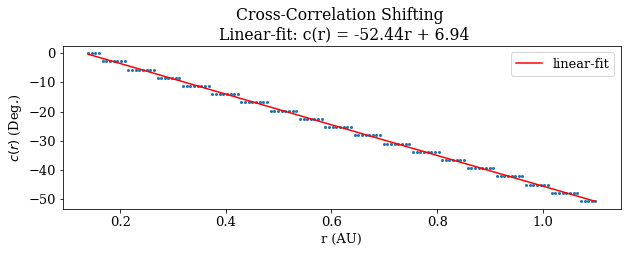

In [11]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), shift_vec, s=4)

n = int(len(r)*0.7)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")
_ = ax.legend()
_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: c(r) = " + str(round(m, 2)) + "r + " + str(round(b, 2)))

In [12]:
def shift_function(r, m, b):
    return m * r + b

In [13]:
def interp_fun(p_shifted, p, t, v):
    # interpolator. 
    my_interpolating_function = RegularGridInterpolator((p, t), v)
    # create new mesh grid. 
    points = np.meshgrid(p_shifted, t)
    # flatten the mesh grid points to align with input for RegularGridInterp function.
    flat = np.array([m.flatten() for m in points])
    # pass to the interp function.
    out_array = my_interpolating_function(flat.T)
    # reshape back to original grid. 
    return out_array.reshape(*points[0].shape)

In [14]:
# initialize the data matrix. 
V_new = np.zeros((len(p), len(t), len(r)))

# initial conditon. 
V_new[:, :, 0] = V[:, :, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
    # define the new shifted coordinate.
    x_new = (p*180/np.pi + shift) % (360)
    # interpolate over the shifted coordinate
    V_new[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=V[:, :, jj]).T

## Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [15]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [16]:
X=V_new

In [17]:
X_train = V_new[:,:, :l]
X_test = V_new[:,:, l:]

In [18]:
r_train = r[:l]
r_test = r[l:]

In [19]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 111, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 111, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Using the ROM Operator Inference Package

## Linear ROM: $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{A}\hat{\mathbf{v}}(r)$


In [20]:
def flatten(X):
    return X.reshape((len(p)*len(t), -1))
    
def undo_flatten(X):
    return X.reshape(len(p), len(t), -1)

def convert_from_x_to_v(X_ROM):
    # intialize the returned matrix. 
    V_ROM = np.zeros(X_ROM.shape)
    # initial condition
    V_ROM[:,:, 0] = X_ROM[:,:, 0]
    # iterate over all r slices. 
    for jj in range(1, len(r)):
        # compute shift from the linear fit above. 
        shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
        # define the new shifted coordinate.
        x_new = (p*180/np.pi - shift) % (360)
        # interpolate over the shifted coordinate
        V_ROM[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=X_ROM[:, :, jj]).T
    return V_ROM

### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$ and rank $r$.

In [21]:
coeff_array = 10**np.arange(0, 10)
rank_array_A = np.arange(10, 60)

training_error_A = np.ones((len(coeff_array), len(rank_array_A), 3)) * np.inf
testing_error_A = np.ones((len(coeff_array), len(rank_array_A), 3)) * np.inf

for kk, coeff in enumerate(coeff_array):
    for jj, rank_r in enumerate(rank_array_A):
        Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank_r) 
        Xdot = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) 
        model = roi.InferredContinuousROM(modelform="A") 
        model.fit(Vr, flatten(X_train), Xdot, P=coeff) 
        X_ROM = model.predict(X[:, :, 0].reshape(len(p)*len(t)), r.value, method="BDF") 
        X_ROM = undo_flatten(X_ROM)

        if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
            V_ROM = convert_from_x_to_v(X_ROM)
            # save
            training_error_A[kk, jj] = np.max(np.abs(V[:, :, :l]-V_ROM[:, :, :l])/V[:, :, :l])
            training_error_A[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM[:, :, :l]), 1)[1]
            training_error_A[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM[:, :, :l]), 2)[1]
            # save
            testing_error_A[kk, jj, 0] = np.max(np.abs(V[:, :, l:]-V_ROM[:, :, l:])/V[:, :, l:])
            testing_error_A[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM[:, :, l:]), 1)[1]
            testing_error_A[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM[:, :, l:]), 2)[1]

In [22]:
idx  = np.unravel_index(training_error_A.argmin(), training_error_A.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array_A[idx[1]])

Training lambda = 1.0
Testing rank = 26


In [23]:
idx  = np.unravel_index(testing_error_A.argmin(), testing_error_A.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array_A[idx[1]])

Training lambda = 2.0
Testing rank = 26


## Quadratic ROM: $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{H} (\hat{\mathbf{v}}(r) \otimes \hat{\mathbf{v}}(r))$

### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$.

In [24]:
coeff_array = 10**np.arange(0, 10)
rank_array_H = np.arange(2, 15)

training_error_H = np.ones((len(coeff_array), len(rank_array_H), 3)) * np.inf
testing_error_H = np.ones((len(coeff_array), len(rank_array_H), 3)) * np.inf

for kk, coeff in enumerate(coeff_array):
    for jj, rank_r in enumerate(rank_array_H):
        Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank_r) 
        Xdot = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) 
        model = roi.InferredContinuousROM(modelform="H") 
        model.fit(Vr, flatten(X_train), Xdot, P=coeff) 
        X_ROM = model.predict(X[:, :, 0].reshape(len(p)*len(t)), r.value, method="BDF") 
        X_ROM = undo_flatten(X_ROM)

        if np.shape(X_ROM) == np.shape(V):
            V_ROM = convert_from_x_to_v(X_ROM)
            # save
            training_error_H[kk, jj, 0] = np.max(np.abs(V[:, :, :l]-V_ROM[:, :, :l])/V[:, :, :l])
            training_error_H[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM[:, :, :l]), 1)[1]
            training_error_H[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM[:, :, :l]), 2)[1]
            # save
            testing_error_H[kk, jj, 0] = np.max(np.abs(V[:, :, l:]-V_ROM[:, :, l:])/V[:, :, l:])
            testing_error_H[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM[:, :, l:]), 1)[1]
            testing_error_H[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM[:, :, l:]), 2)[1]

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:185: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


In [25]:
idx  = np.unravel_index(training_error_H.argmin(), training_error_H.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array_H[idx[1]])

Training lambda = 5.0
Testing rank = 13


In [26]:
idx  = np.unravel_index(testing_error_H.argmin(), testing_error_H.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array_H[idx[1]])

Testing lambda = 5.0
Testing rank = 5


In [27]:
def d_A(r):
    return r*r

def d_H(r):
    return r*(r*(r+1)/2)

def d_cAH(r):
    return r*(r + r*(r+1)/2 + 1)

## Quadratic + Linear ROM: $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{c} + \hat{A}\hat{\mathbf{v}}(r) +\hat{H} (\hat{\mathbf{v}}(r) \otimes \hat{\mathbf{v}}(r))$

In [28]:
coeff1_array = 10**np.arange(0, 10)
coeff2_array = 10**np.arange(0, 10)
rank_array_cAH = np.arange(2, 15)

training_error_cAH = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array_cAH), 3)) * np.inf
testing_error_cAH = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array_cAH), 3)) * np.inf

for kk, coeff1 in enumerate(coeff1_array):
    for jj, coeff2 in enumerate(coeff2_array):
        for pp, rank_r, in enumerate(rank_array_cAH):
            Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank_r) 
            Xdot = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) 
            model = roi.InferredContinuousROM(modelform="cAH") 
            model.fit(Vr, flatten(X_train), Xdot, P=regularizer(rank_r, coeff1, coeff2)) 
            X_ROM = model.predict(X[:, :, 0].reshape(len(p)*len(t)), r.value, method="BDF") 
            X_ROM = undo_flatten(X_ROM)

            if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
                V_ROM = convert_from_x_to_v(X_ROM)
                # save
                training_error_cAH[kk, jj, pp, 0] = np.max(np.abs(V[:, :, :l]-V_ROM[:, :, :l])/V[:, :, :l])
                training_error_cAH[kk, jj, pp, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM[:, :, :l]), 1)[1]
                training_error_cAH[kk, jj, pp, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM[:, :, :l]), 2)[1]
                # save
                testing_error_cAH[kk, jj, pp, 0] = np.max(np.abs(V[:, :, l:]-V_ROM[:, :, l:])/V[:, :, l:])
                testing_error_cAH[kk, jj, pp, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM[:, :, l:]), 1)[1]
                testing_error_cAH[kk, jj, pp, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM[:, :, l:]), 2)[1]

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: 

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: 

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: 

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required st

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required st

normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: Inte

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: Inte

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: Inte

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: Inte

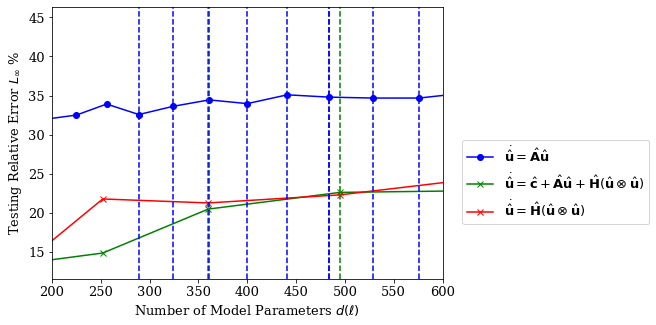

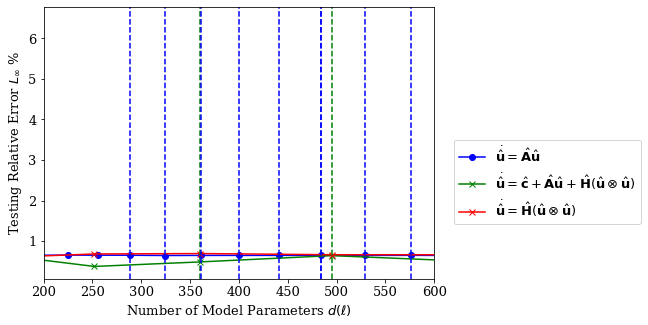

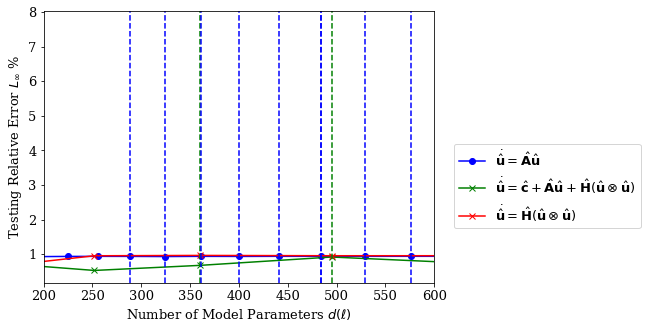

In [29]:
for norms in range(3):
    fig, ax = plt.subplots(figsize=(7, 5))
    A_results_testing = np.zeros(len(rank_array_A))
    H_results_testing = np.zeros(len(rank_array_H))
    cAH_results_testing = np.zeros(len(rank_array_cAH))

    for ii in range(len(rank_array_cAH)):
        # optimal coefficients based on training error
        coeff_cAH = np.unravel_index(training_error_cAH[:, :, ii, 0].argmin(), training_error_cAH[:, :, ii, 0].shape)
        cAH_results_testing[ii] = 100*testing_error_cAH[coeff_cAH[0], coeff_cAH[1], ii, norms]

    for ii in range(len(rank_array_A)):
        # optimal coefficients based on training error
        coeff_A = np.argmin(training_error_A[:, ii, 0])
        # save the corresponding testing error
        A_results_testing[ii] = 100*testing_error_A[coeff_A, ii, norms]
    
    for ii in range(len(rank_array_H)):
        # optimal coefficients based on training error
        coeff_H = np.argmin(training_error_H[:, ii, 0])
        # save the corresponding testing error
        H_results_testing[ii] = 100*testing_error_H[coeff_H, ii, norms]

    ax.plot(d_A(rank_array_A), A_results_testing,"-o", c="b", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{A}}\hat{\mathbf{u}}$")
    ax.plot(d_cAH(rank_array_cAH), cAH_results_testing,"-x", c="g", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{c}} + \hat{\mathbf{A}}\hat{\mathbf{u}}+ \hat{\mathbf{H}}(\hat{\mathbf{u}} \otimes \hat{\mathbf{u}})$")
    ax.plot(d_cAH(rank_array_H), H_results_testing,"-x", c="r", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{H}}(\hat{\mathbf{u}} \otimes \hat{\mathbf{u}})$")

    ax.axvline(d_cAH(10), ls="--", c="g")
    ax.axvline(d_cAH(9), ls="--", c="g")
    ax.axvline(d_cAH(8), ls="--", c="g")

    ax.axvline(d_A(24), ls="--", c="b")
    ax.axvline(d_A(23), ls="--", c="b")
    ax.axvline(d_A(22), ls="--", c="b")
    ax.axvline(d_A(21), ls="--", c="b")
    ax.axvline(d_A(20), ls="--", c="b")
    ax.axvline(d_A(22), ls="--", c="b")
    ax.axvline(d_A(19), ls="--", c="b")
    ax.axvline(d_A(18), ls="--", c="b")
    ax.axvline(d_A(17), ls="--", c="b")


#    _ = ax.text(d_cAH(9)+2, 38,  "$\ell=9$", c="g", rotation=90, verticalalignment='center')
#     _ = ax.text(d_cAH(8)+2, 38,  "$\ell=8$", c="g", rotation=90, verticalalignment='center')

#     _ = ax.text(d_A(24)-15, 13,  "$\ell=24$", c="b", rotation=90, verticalalignment='center')
#     _ = ax.text(d_A(23)-15, 13,  "$\ell=23$", c="b", rotation=90, verticalalignment='center')
#     _ = ax.text(d_A(22)-15, 13,  "$\ell=22$", c="b", rotation=90, verticalalignment='center')
#     _ = ax.text(d_A(21)-15, 13,  "$\ell=21$", c="b", rotation=90, verticalalignment='center')
#     _ = ax.text(d_A(20)-15, 13,  "$\ell=20$", c="b", rotation=90, verticalalignment='center')
#     _ = ax.text(d_A(19)-15, 13,  "$\ell=19$", c="b", rotation=90, verticalalignment='center')
#     _ = ax.text(d_A(18)-15, 13,  "$\ell=18$", c="b", rotation=90, verticalalignment='center')
#     _ = ax.text(d_A(17)-15, 13,  "$\ell=17$", c="b", rotation=90, verticalalignment='center')

    _ = ax.legend(loc=(1.05, .2))
    _ = ax.set_xlim(200, 600)
    #_ = ax.set_ylim(10, 40)
    _ = ax.set_ylabel("Testing Relative Error $L_{\infty}$ %")
    _ = ax.set_xlabel(r"Number of Model Parameters $d(\ell)$")

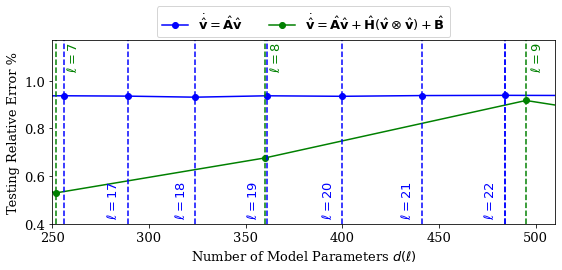

In [57]:
fig, ax = plt.subplots(figsize=(8, 4))
A_results_testing = np.zeros(len(rank_array_A))
H_results_testing = np.zeros(len(rank_array_H))
cAH_results_testing = np.zeros(len(rank_array_cAH))

for ii in range(len(rank_array_cAH)):
    # optimal coefficients based on training error
    coeff_cAH = np.unravel_index(training_error_cAH[:, :, ii, 0].argmin(), training_error_cAH[:, :, ii, 0].shape)
    cAH_results_testing[ii] = 100*testing_error_cAH[coeff_cAH[0], coeff_cAH[1], ii, 2]

for ii in range(len(rank_array_A)):
    # optimal coefficients based on training error
    coeff_A = np.argmin(training_error_A[:, ii, 0])
    # save the corresponding testing error
    A_results_testing[ii] = 100*testing_error_A[coeff_A, ii, 2]

for ii in range(len(rank_array_H)):
    # optimal coefficients based on training error
    coeff_H = np.argmin(training_error_H[:, ii, 0])
    # save the corresponding testing error
    H_results_testing[ii] = 100*testing_error_H[coeff_H, ii, 2]

ax.plot(d_A(rank_array_A), A_results_testing,"-o", c="b", label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}}\hat{\mathbf{v}}$")
ax.plot(d_cAH(rank_array_cAH), cAH_results_testing,"-o", c="g", label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}}\hat{\mathbf{v}}+ \hat{\mathbf{H}}(\hat{\mathbf{v}} \otimes \hat{\mathbf{v}}) + \hat{\mathbf{B}}$")

ax.axvline(d_cAH(7), ls="--", c="g")
ax.axvline(d_cAH(9), ls="--", c="g")
ax.axvline(d_cAH(8), ls="--", c="g")

_ = ax.text(d_cAH(7)+5, 1.1,  "$\ell=7$", c="g", rotation=90, verticalalignment='center')
_ = ax.text(d_cAH(9)+2, 1.1,  "$\ell=9$", c="g", rotation=90, verticalalignment='center')
_ = ax.text(d_cAH(8)+2, 1.1,  "$\ell=8$", c="g", rotation=90, verticalalignment='center')

# ax.axvline(d_H(8), ls="--", c="r")
# ax.axvline(d_H(9), ls="--", c="r")
# _ = ax.text(d_H(8)+2, 1.11,  "$\ell=8$", c="r", rotation=90, verticalalignment='center')
# _ = ax.text(d_H(9)+2, 1.11,  "$\ell=9$", c="r", rotation=90, verticalalignment='center')

ax.axvline(d_A(24), ls="--", c="b")
ax.axvline(d_A(23), ls="--", c="b")
ax.axvline(d_A(22), ls="--", c="b")
ax.axvline(d_A(21), ls="--", c="b")
ax.axvline(d_A(20), ls="--", c="b")
ax.axvline(d_A(22), ls="--", c="b")
ax.axvline(d_A(19), ls="--", c="b")
ax.axvline(d_A(18), ls="--", c="b")
ax.axvline(d_A(17), ls="--", c="b")
ax.axvline(d_A(16), ls="--", c="b")

_ = ax.text(d_A(22)-11, 0.5,  "$\ell=22$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(21)-11, 0.5,  "$\ell=21$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(20)-11, 0.5,  "$\ell=20$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(19)-11, 0.5,  "$\ell=19$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(18)-11, 0.5,  "$\ell=18$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(17)-11, 0.5,  "$\ell=17$", c="b", rotation=90, verticalalignment='center')


_ = ax.legend(bbox_to_anchor=[0.5, 1.1],loc='center', ncol=2)
_ = ax.set_xlim(250, 510)
_ = ax.set_ylim(0.4, 1.17)
_ = ax.set_ylabel("Testing Relative Error %")
_ = ax.set_xlabel(r"Number of Model Parameters $d(\ell)$")
plt.tight_layout()
plt.savefig("MHD/figs/number_of_model_parameters_MAS3D.png")


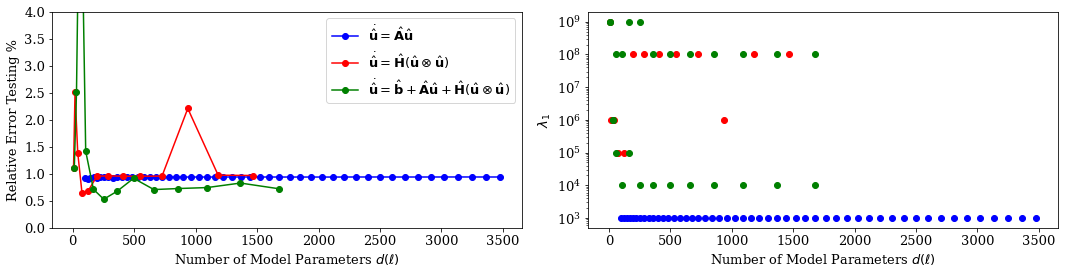

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

A_results_testing = np.zeros(len(rank_array_A))
H_results_testing = np.zeros(len(rank_array_H))
cAH_results_testing = np.zeros(len(rank_array_cAH))

for ii in range(len(rank_array_A)):
    # optimal coefficients based on training error
    coeff_A = np.argmin(training_error_A[:, ii, 0])
    # save the corresponding testing error
    A_results_testing[ii] = 100*testing_error_A[coeff_A, ii, 2]
    # plot coefficient
    ax[1].scatter(d_A(rank_array_A[ii]), 10**coeff_A, c="blue")
    

for ii in range(len(rank_array_H)):
    # optimal coefficients based on training error
    coeff_H = np.argmin(training_error_H[:, ii, 0])
    # save the corresponding testing error
    H_results_testing[ii] = 100*testing_error_H[coeff_H, ii, 2]
    # plot coefficient
    ax[1].scatter(d_H(rank_array_H[ii]), 10**coeff_H, c="red")
    

for ii in range(len(rank_array_cAH)):
    # optimal coefficients based on training error
    coeff_cAH = np.unravel_index(training_error_cAH[:, :, ii, 0].argmin(), training_error_cAH[:, :, ii, 0].shape)
    cAH_results_testing[ii] = 100*testing_error_cAH[coeff_cAH[0], coeff_cAH[1], ii, 2]
    ax[1].scatter(d_cAH(rank_array_cAH[ii]), 10**coeff_cAH[0], c="green")
    ax[1].scatter(d_cAH(rank_array_cAH[ii]), 10**coeff_cAH[1], c="green")
    
ax[1].set_yscale("log")

ax[0].plot(d_A(rank_array_A), A_results_testing,"-o", c="b", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{A}}\hat{\mathbf{u}}$")
ax[0].plot(d_H(rank_array_H), H_results_testing,"-o", c="red", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{H}}(\hat{\mathbf{u}} \otimes \hat{\mathbf{u}})$")
ax[0].plot(d_cAH(rank_array_cAH), cAH_results_testing,"-o", c="g", label="$\dot{\hat{\mathbf{u}}} =  \hat{\mathbf{b}} + \hat{\mathbf{A}}\hat{\mathbf{u}} + \hat{\mathbf{H}}(\hat{\mathbf{u}} \otimes \hat{\mathbf{u}})$")
#ax[0].set_xlim(200, 1500)
ax[0].set_ylim(0, 4)
#ax[1].set_xlim(200, 1500)
ax[0].legend()

_ = ax[1].set_xlabel(r"Number of Model Parameters $d(\ell)$")
_ = ax[0].set_xlabel(r"Number of Model Parameters $d(\ell)$")
_ = ax[1].set_ylabel(r"$\lambda_{1}$")
_ = ax[0].set_ylabel(r"Relative Error Testing %")
plt.tight_layout()